# Parameterized Quantum Circuits

Variational algorithms operate by exploring a range of quantum states $|\psi(\vec\theta)\rangle$, which depend on a finite set of $k$ parameters $\vec\theta = (\theta^0, \ldots, \theta^{k-1})$. These states can be prepared using a parameterized quantum circuit, where the gates are defined with tunable parameters. It is possible to create this parameterized circuit without assigning the specific angles yet.

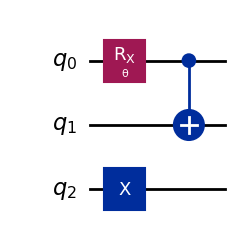

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl", style="iqp")

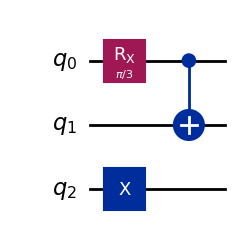

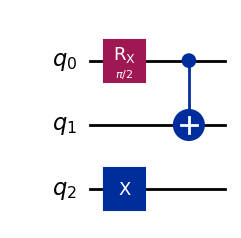

In [5]:
from math import pi

angle_list = [pi / 3, pi / 2]
circuits = [qc.assign_parameters({theta: angle}) for angle in angle_list]

for circuit in circuits:
    display(circuit.draw("mpl", style="iqp"))

# Variational Form and Ansatz

The amount of parameterized states for our variational algorithm to explore suffers from the curse of dimensionality. This means that the number of parameters grows exponentially with the number of qubits. Quantitatively, the dimensionality is $D = 2^{2n}$. Along with the dimensionality, the runtime grows exponentially with the number of parameters. To counter this, we can find reasonable constraints on the variational form, such that only relevant states are explored. Finding an efficient truncated ansatz is an active area of research, but we cover two common designs.

## Heuristic ansatze and trade-offs

If you have no information about the particular problem that can help restrict the dimensionality, you can try an arbitrary family of parameterized circuits with fewer than $2^{2n}$ parameters. However, this approach has some considerable trade-offs:
- Speed: By reducing the search space, the algorithm can converge faster.
- Accuracy: The algorithm may miss the optimal solution if the ansatz is not expressive enough.
- Noise: The algorithm may be more robust to noise if the ansatz is not too expressive, so we need to experiment with our ansatz's connectivity, gates and gate fidelity.

There is a fundamental trade-off between quality (or even solvability) and speed: the more parameters, the more likely you are to find a good solution, but the longer it will take to find it.

### N-local circuits

One of the most common examples of heuristic ansatzes is the N-local circuit, for the following reasons:
- Efficient implementation: The N-local ansatz is typically composed of simple, local gates that can be implemented efficiently on quantum hardware, using a small number of qubits.
- Captures important correlations: The N-local ansatz can capture important correlations between the qubits in a quantum system, even with a small number of gates. This is because the local gates can act on neighboring qubits and create entanglement between them.

These circuits consist of rotation and entanglement layers that are repeated alternatively one or more times as follows:
- Each layer is formed by gates of size at most $N$, where $N$ has to be lower than the number of qubits.
- FOr a rotation layer, the gates are stacked on top of each other. We can use standard rotation operations, such as $RX$ or $CRZ$. 
- For an entanglement layer, we can use gates like `Toffoli` ($CCNOT$) or $CX$ gates with an entanglement strategy.
- Both types of layers can be parameterized or not, but at least one of them needs to contain parameters. Otherwise, without at least one parameter, there wouldn't be any variations!
- Optionally, an extra rotation layer is added to the end of the circuit.

For example, lets create a 5-qubit `NLocal` circuit with rotation blocks formed by $RX$ and $CRZ$ gates, entanglement blocks formed by `Toffoli` gates that act on qubits $[0,1,2], [0,2,3], [4,2,1]$ and $[3,1,0]$ and $2$ repetitions of the layers.

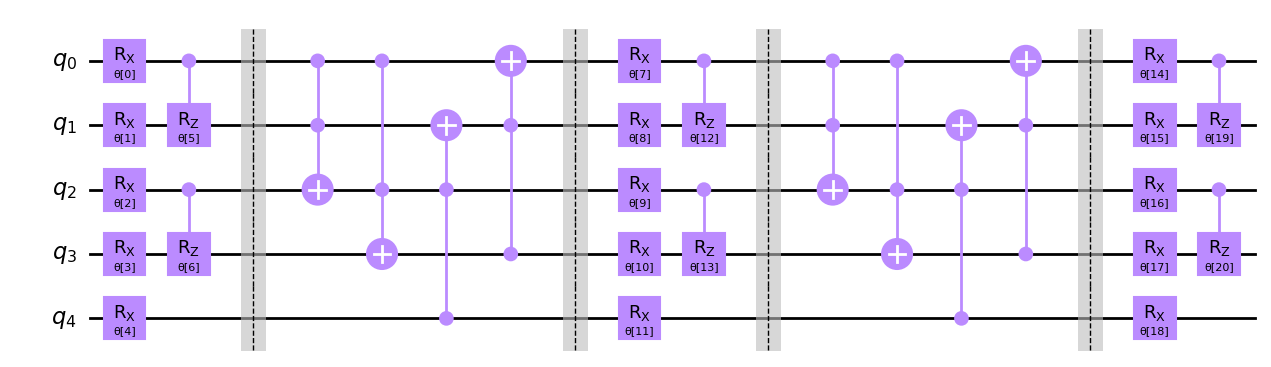

In [18]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")

ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

The most commonly used type of $N$-local circuits are $2$-local circuits with single-qubit rotation gates and $2$-qubit entanglement gates.

Let's create a $2$-local circuit using Qiskit's `TwoLocal` class. The syntax is the same as `NLocal`, but there are some differences. For instance, most gates, such as $RX$, $RZ$, and $CNOT$, can be passed as strings without importing the gates or creating a Parameter instance.

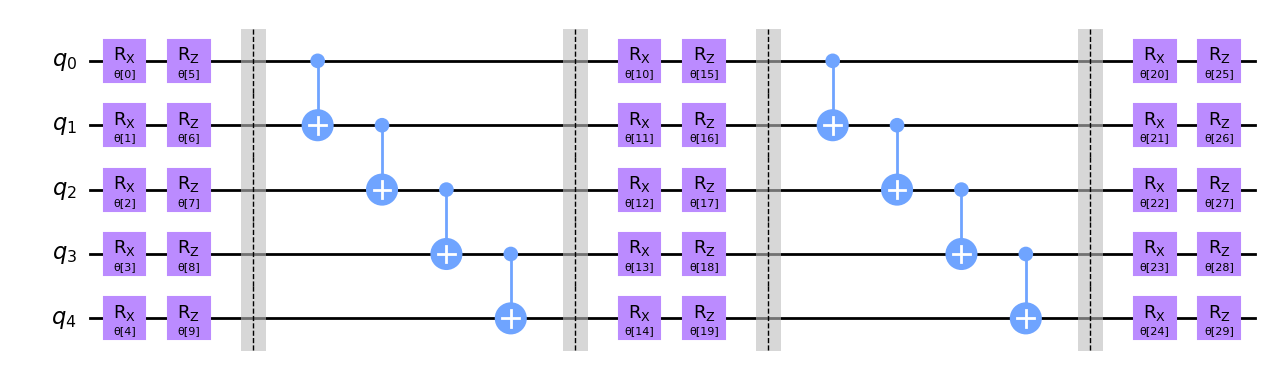

In [15]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

In this case, we used the linear entanglement distribution, where each qubit is entangled with the next. To learn about other strategies, refer to `TwoLocal`'s [ documentation ](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal).

### EfficientSU2

`EfficientSU2` is a hardware-efficient circuit that consists of layers of single-qubit operations spanning SU(2) and $CX$ entanglements. This is a heuristic pattern that can be used to prepare trial wave functions for variational quantum algorithms or as a classification circuit for machine learning.

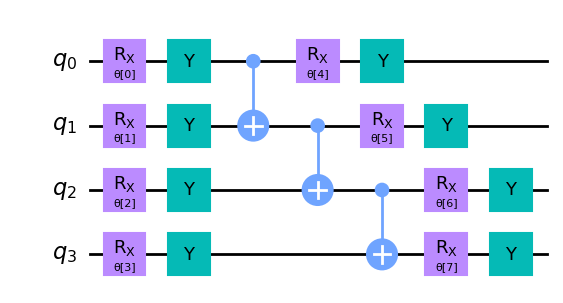

In [16]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")

## Problem-specific ansatze

Heuristic and hardware efficient ansatze can help us to solve problems in a naive way, but we can use problem-specific knowledge to restrict our circuit search space to a specific type. This helps us gain speed _without_ losing accuracy in our search process.

### Optimization

In a max-cut problem, we want to partition nodes of a graph in a way that maximizes the number of edges between nodes in differing groups. The desired max-cut partition for the graph below is clear: the 0th-node on the left should be separated from the rest of the nodes on the right by a cut.

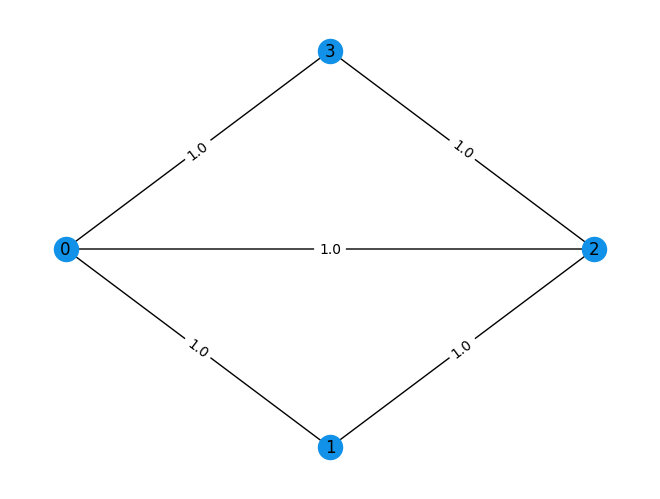

In [19]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

To utilize QAOA algorithm for a max-cut problem, we require a Pauli Hamiltonian that encodes the cost in a manner such that the minimum expectation value of the operator corresponds to the maximum number of edges between the nodes in two different groups.

For this simple example, the operator is a linear combination of terms with $Z$ operators, on nodes connected by an edge (recall that the 0th qubit is the farthest right): $IIIZZ + IIZIZ + IZIIZ + ZIIIZ$. Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz` circuit from the Qiskit circuit library.

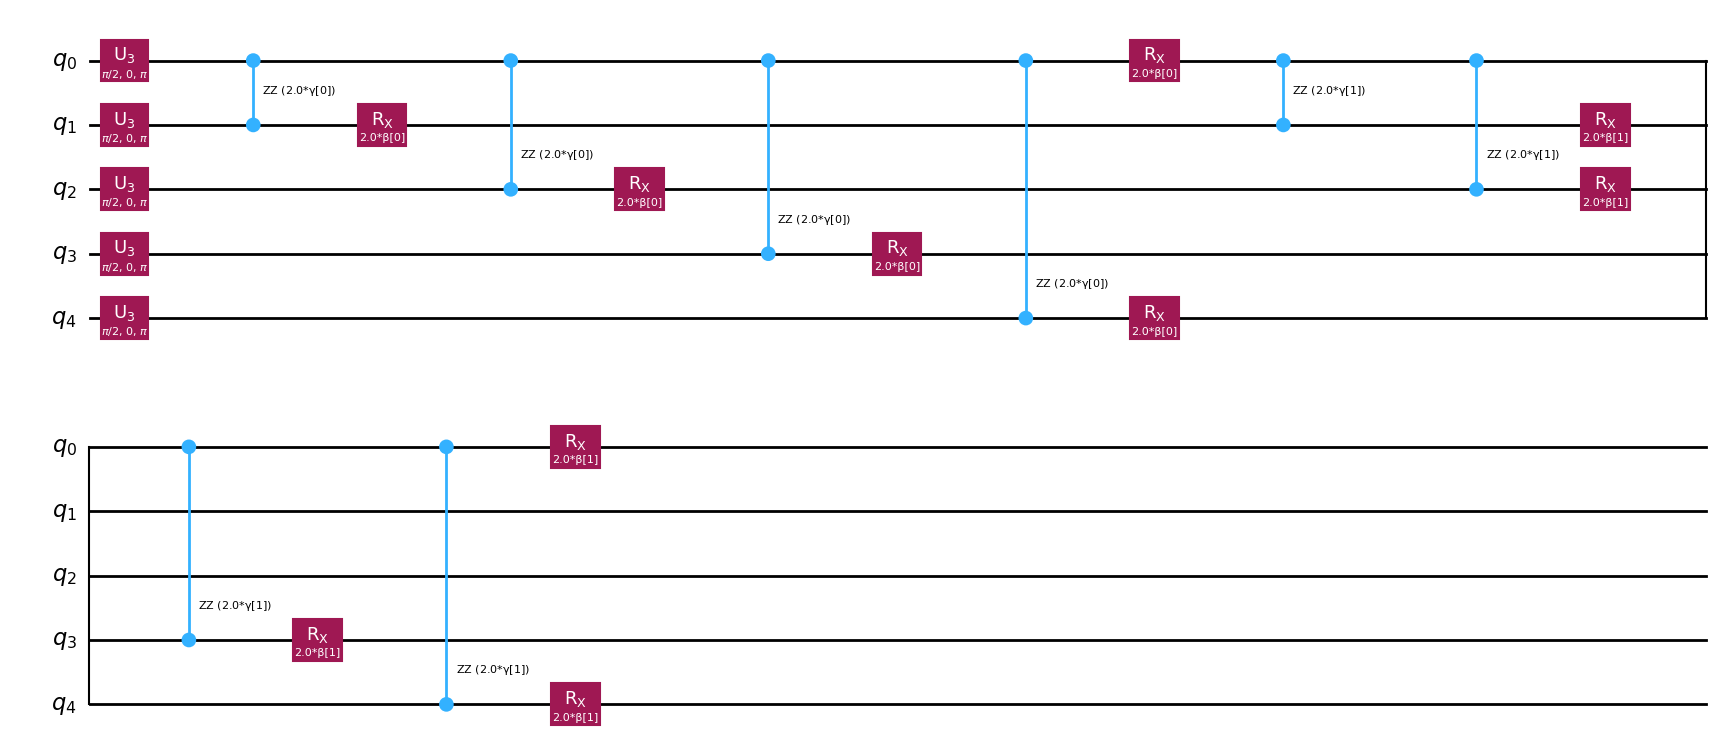

In [21]:
# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl", style="iqp")

The previous image illustrates the ansatz in basic gates for clarity. However, it can be expressed in multiple levels of decomposition by changing the `reps` parameter.

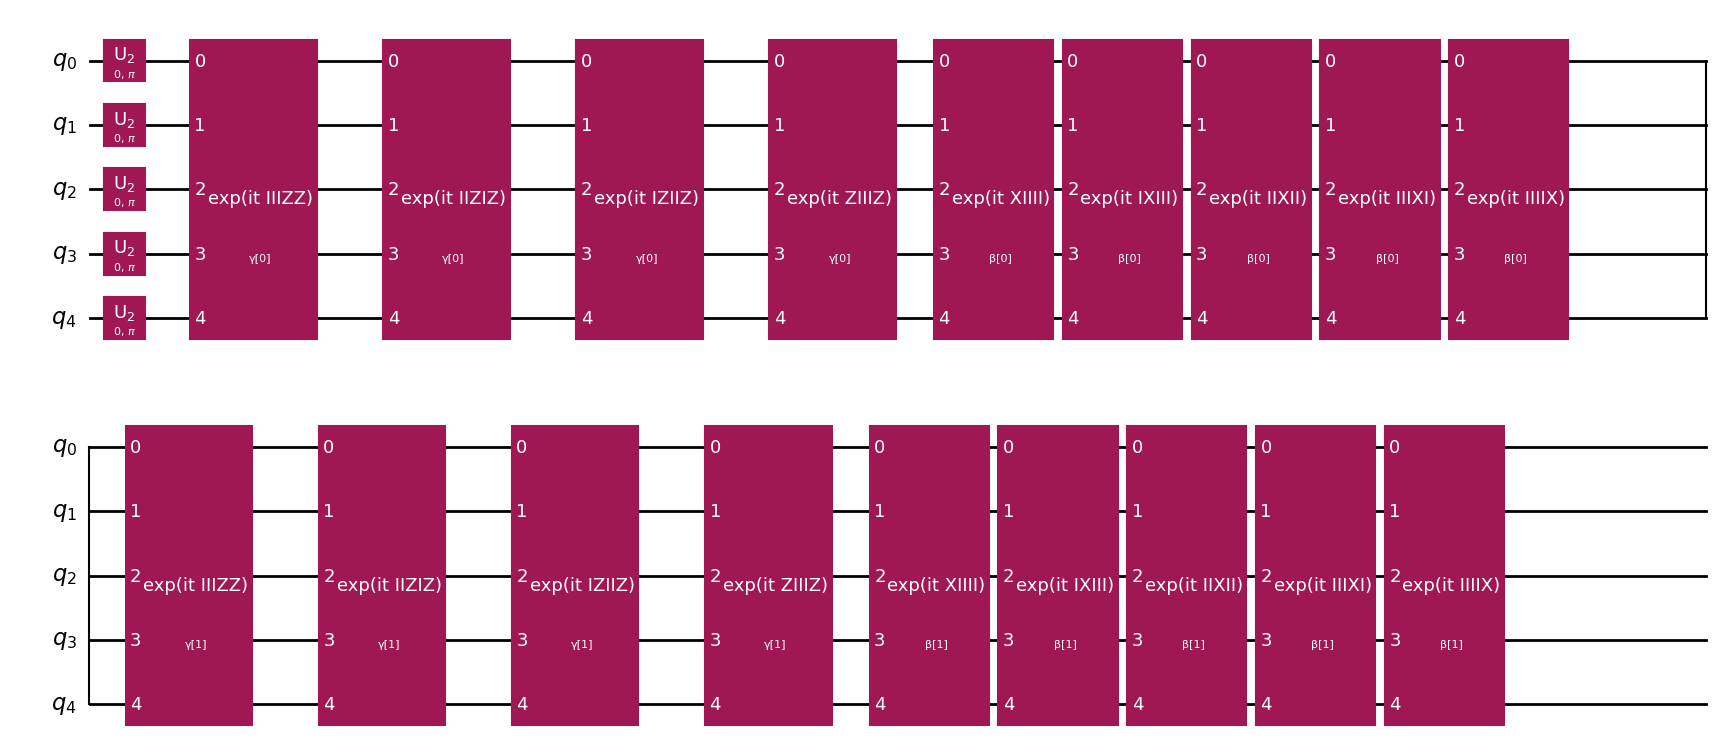

In [22]:
ansatz.decompose(reps=2).draw("mpl", style="iqp")

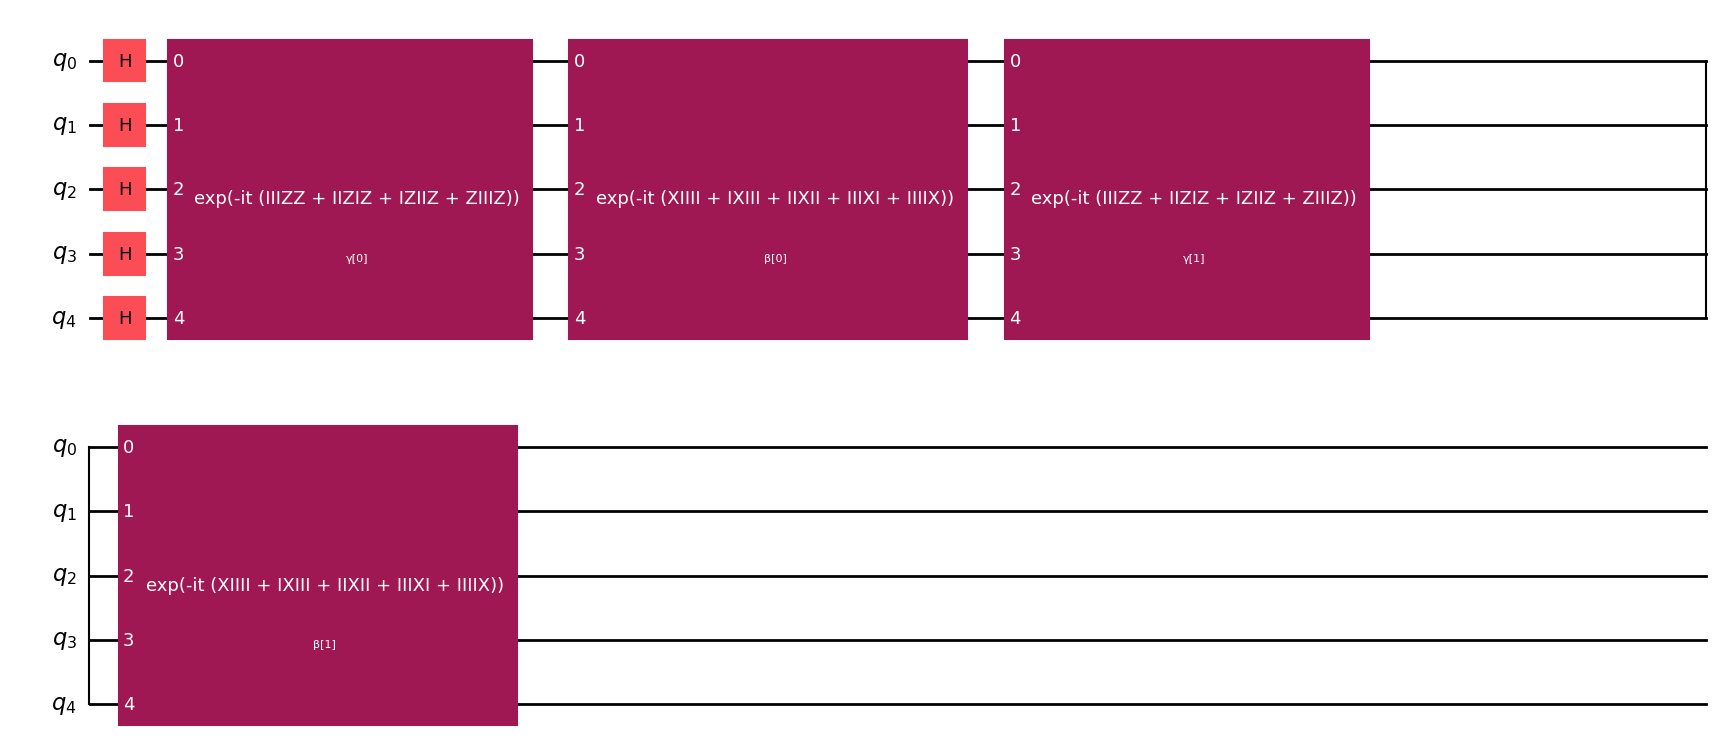

In [24]:
ansatz.decompose().draw('mpl', style='iqp')

### Quantum Machine Learning

A common application in machine learning is the classification of data into two or more categories. This involves encoding a datapoint into a feature map that maps classical feature vectors into the quantum Hilbert space. Constructing quantum feature maps based on parameterized quantum circuits that are hard to simulate classically is an important step towards obtaining a potential advantage over classical machine learning approaches and is an active area of research.

The `ZZFeatureMap` can be used to create a parameterized circuit. We can pass in our data points to the feature map ($x$) and a separate variational form to pass in weights as parameters ($\theta$).

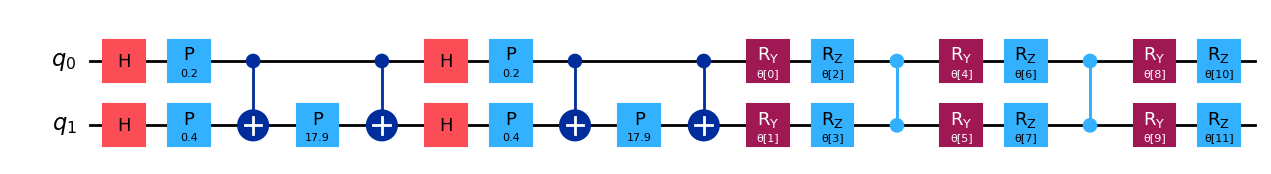

In [29]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

data = [0.1, 0.2]

zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference = zz_feature_map_reference.assign_parameters(data)

variation_form = TwoLocal(2, ["ry", "rz"], "cz", reps=2)
vqc_ansatz = zz_feature_map_reference.compose(variation_form)
vqc_ansatz.decompose().draw("mpl", style="iqp")